In [1]:
import os
import sys
import flopy
import numpy as np
import pandas as pd
from osgeo import gdal
import pyemu

np.set_printoptions(threshold=sys.maxsize)

In [2]:
#import shapefile
import flopy.utils.binaryfile as bf
from flopy.utils.reference import SpatialReference
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
workspace = "workspace"
model_name = "mf6model"
exe_name="mf6.exe"

In [4]:
### Loading raster layers for the 4 layer model

# Top layer:
PathTop = os.path.join("Superficie.tif")
demDs = gdal.Open(PathTop)
Superficie_Total = demDs.GetRasterBand(1).ReadAsArray()
geot = demDs.GetGeoTransform()

# Layer 1. Limos Rojos
Limos = os.path.join("EspLimos.tif")
demDsLimos = gdal.Open(Limos)
Espesor_Limos = demDsLimos.GetRasterBand(1).ReadAsArray()

# Layer 2. Gravoso
Gravoso = os.path.join("EspGravoso.tif")
demDsGravoso = gdal.Open(Gravoso)
Espesor_Gravoso = demDsGravoso.GetRasterBand(1).ReadAsArray()

# Layer 3. Finos
Finos = os.path.join("EspFinos.tif")
demDsFinos = gdal.Open(Finos)
Espesor_Finos = demDsFinos.GetRasterBand(1).ReadAsArray()

# Layer 4. Órganos
Organos = os.path.join("EspOrganos.tif")
demDsOrganos = gdal.Open(Organos)
Espesor_Organos = demDsOrganos.GetRasterBand(1).ReadAsArray()

# heads raster Capa 2: Gravoso
headPath_2 = "Carga Hidráulica.tif"
headDs_2 = gdal.Open(headPath_2)
headData_2 = headDs_2.GetRasterBand(1).ReadAsArray()
#headData_2[headData_2 < 0] = 0

# heads raster Capa 4: Órganos
headPath_4 = "Carga_Organos.tif"
headDs_4 = gdal.Open(headPath_4)
headData_4 = headDs_4.GetRasterBand(1).ReadAsArray()
#headData_4[headData_4 < 0] = 0

### River stage and bottom rasters
RiverPathStage = os.path.join(r"Rios_CortadoStage.tif")
demRiverStage = gdal.Open(RiverPathStage)
RiverStage = demRiverStage.GetRasterBand(1).ReadAsArray()
#RiverStage[RiverStage < 0] = 0

RiverPathBottom = os.path.join(r"Rios_CortadoBottom.tif")
demRiverBottom = gdal.Open(RiverPathBottom)
RiverBottom = demRiverBottom.GetRasterBand(1).ReadAsArray()
#RiverBottom[RiverBottom < 0] = 0

In [5]:
### Initial condition of the model
# Spatial Reference Module
xll, yll = 1098000, 1271000 # model origin
xul, yul = 1098000, 1285000 
# Pixel size
delr = int(geot[1])
delc = int(abs(geot[5]))
# num of layers, num of cols an rows
nlay = 4
ncol = demDs.RasterXSize
nrow = demDs.RasterYSize
rot = 0
# Specify coordinate system 
#sr = SpatialReference(delr=np.ones(nrow, dtype=float) * delr, delc=np.ones(nrow, dtype=float) * delc, xll=xll, yll=yll, rotation=0, epsg='3116')

In [6]:
#sr = flopy.discretization.StructuredGrid(delr=delr, delc=delc)
sr = flopy.utils.SpatialReference(delr=(np.ones(nrow, dtype=float) * delr),
                                  delc=(np.ones(nrow, dtype=float) * delc), lenuni=2,
                                  xul=xul, yul=yul, rotation=0, epsg='3116')
sr

xul:1098000; yul:1285000; rotation:0; proj4_str:+proj=tmerc +lat_0=4.596200416666666 +lon_0=-74.07750791666666 +k=1 +x_0=1000000 +y_0=1000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs ; units:meters; lenuni:2; length_multiplier:1.0

In [7]:
# Thicknes of all 4 layers as a vector
Espesores = [Espesor_Limos, Espesor_Gravoso, Espesor_Finos, Espesor_Organos]

In [8]:
# Top layer raster
ztop = Superficie_Total

# Subtracting top layer to the thickness of each layer to get the bottom
zbot = np.zeros((nlay, nrow, ncol), dtype=np.float32)

zbot[0,:,:] = ztop - Espesores[0]
for lay in range(1,nlay):
    zbot[lay,:,:] = zbot[lay-1,:,:] - Espesores[lay]    
 
    
#zbot[1,:,:] = zbot[0,:,:] - Espesores[1]    
#zbot[2,:,:] = zbot[1,:,:] - Espesores[2]
#zbot[3,:,:] = zbot[2,:,:] - Espesores[3]

### Graphic representation of rasters for each layer

In [9]:
# Model Extent
xmin = xll
xmax = 1110000
ymin = yll
ymax = 1285000
extent = (xmin, xmax , ymin, ymax)
x = np.arange(xmin, ymax, 50)
y = np.arange(xmin, ymax, 50)
X,Y= np.meshgrid(x,y)

<Figure size 432x288 with 0 Axes>

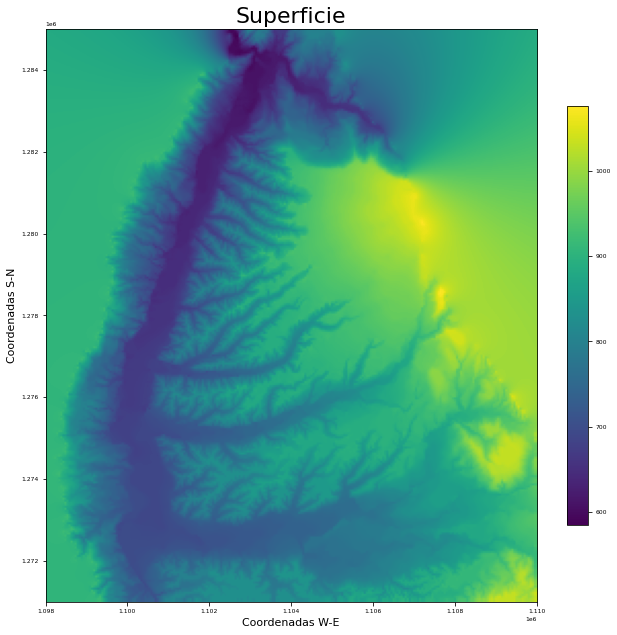

<Figure size 432x288 with 0 Axes>

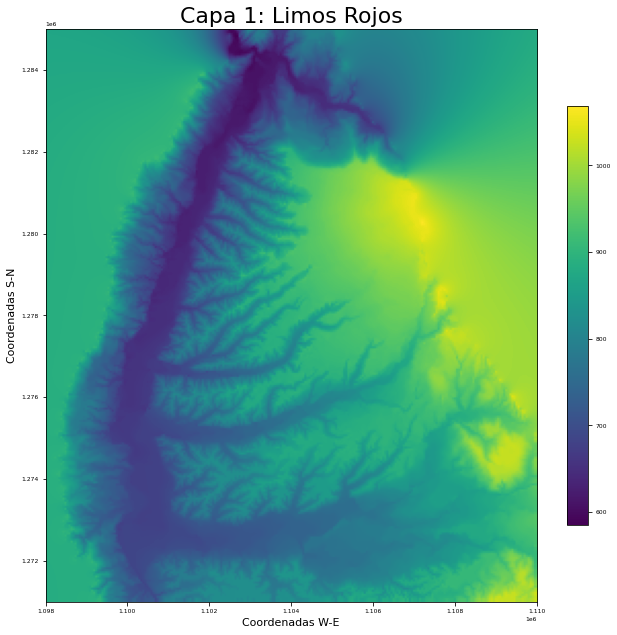

<Figure size 432x288 with 0 Axes>

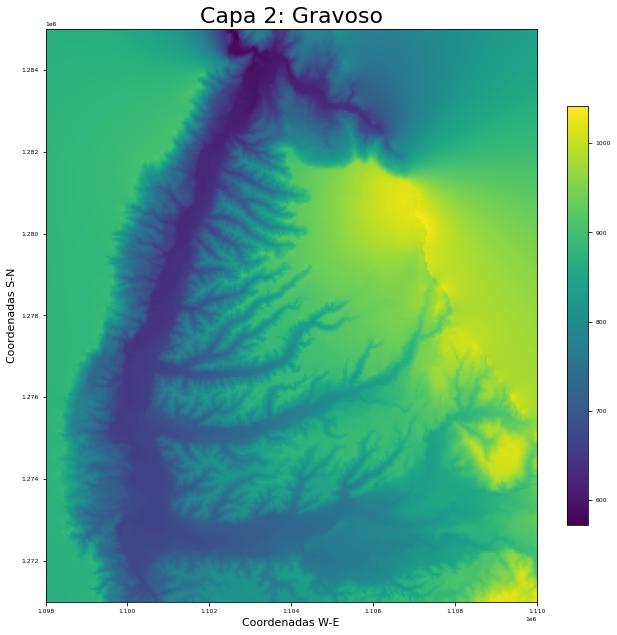

<Figure size 432x288 with 0 Axes>

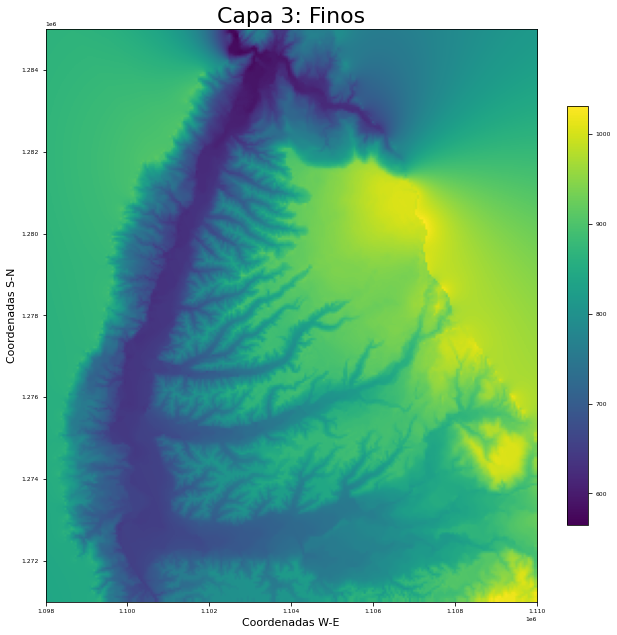

<Figure size 432x288 with 0 Axes>

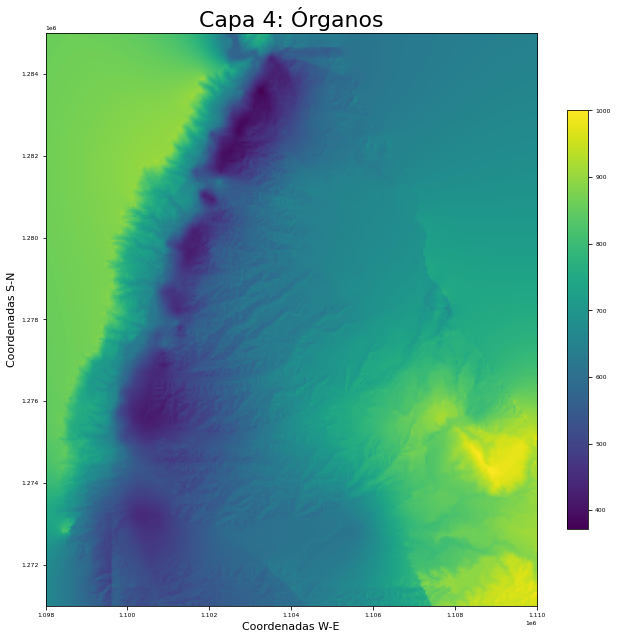

In [10]:
# TOP of the model
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
#zbot[0][zbot[0]>1.0e+38]=0    #These are no data values
#zbot[0][zbot[0]<-1.0e+38]=0   #These are no data values

plt.imshow(ztop,extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Superficie',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Superficie del terreno - ztop')

# LIMOS ROJOS LAYER 1
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
#zbot[0][zbot[0]>1.0e+38]=0
#zbot[0][zbot[0]<-1.0e+38]=0

plt.imshow(zbot[0],extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Capa 1: Limos Rojos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Bottom de Limos Rojos - zbot 1')

# GRAVOSO LAYER 2
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
#zbot[1][zbot[1]>1.0e+38]=0
#zbot[1][zbot[1]<-1.0e+38]=0

plt.imshow(zbot[1],extent = extent)
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Capa 2: Gravoso',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Bottom de Gravoso - zbot 2')

# FINOS LAYER 3
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
#zbot[2][zbot[2]>1.0e+38]=0
#zbot[2][zbot[2]<-1.0e+38]=0

plt.imshow(zbot[2],extent = extent)
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Capa 3: Finos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Bottom de Finos - zbot 3')


# ÓRGANOS LAYER 4
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
#zbot[3][zbot[3]>1.0e+38]=0
#zbot[3][zbot[3]<-1.0e+38]=0

plt.imshow(zbot[3],extent = extent)
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Capa 4: Órganos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Bottom de Órganos - zbot 4')

<Figure size 432x288 with 0 Axes>

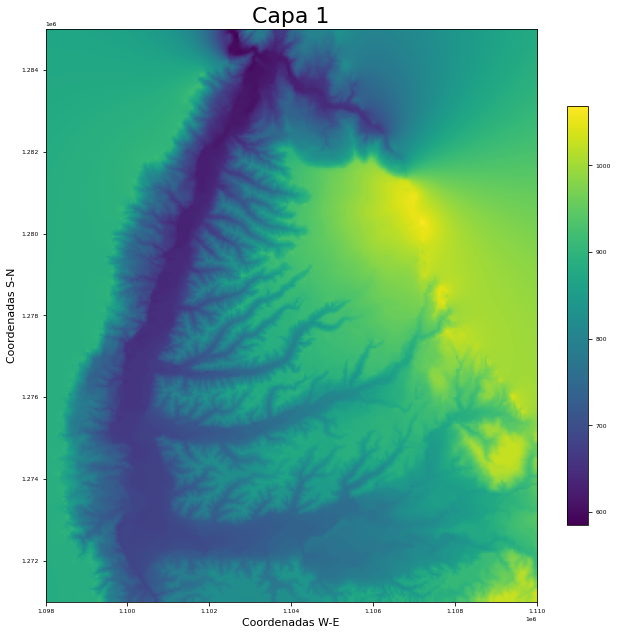

<Figure size 432x288 with 0 Axes>

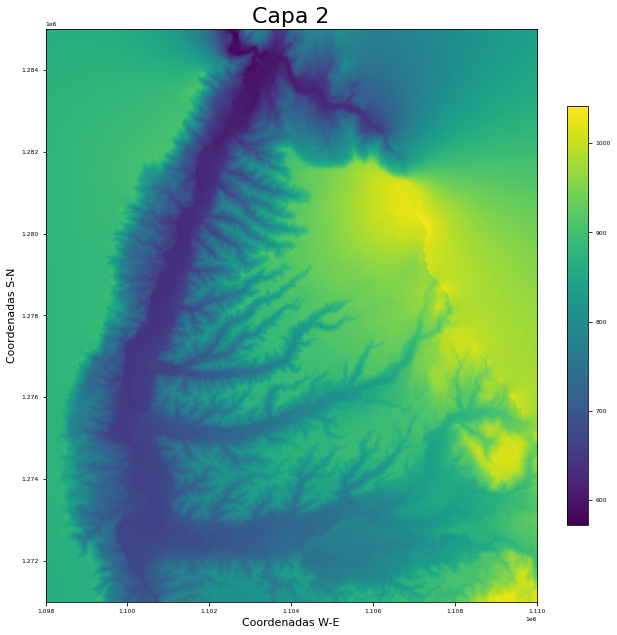

<Figure size 432x288 with 0 Axes>

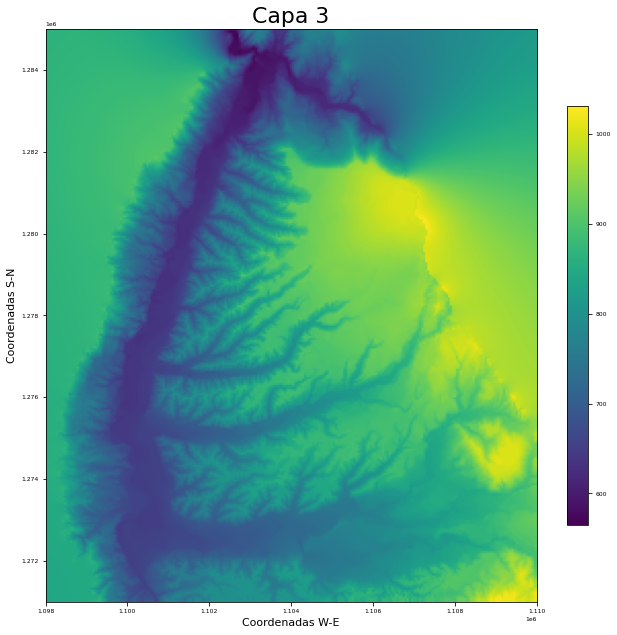

<Figure size 432x288 with 0 Axes>

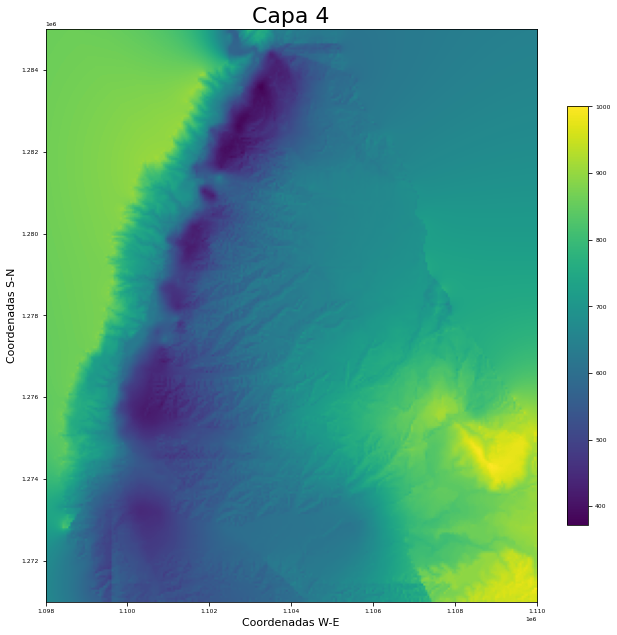

In [11]:
for ilay in range(4):  
    plt.figure()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
    plt.imshow((zbot[ilay]),extent = extent) 
    
    plt.xlabel('Coordenadas W-E',fontsize=11)
    plt.ylabel('Coordenadas S-N',fontsize=11)
    plt.title('Capa {}'.format(ilay + 1),fontsize = 22)
    plt.colorbar(shrink=0.7,ax=ax);
    #plt.savefig(fname='Capa {}'.format(ilay + 1))
   #ax = axes[ilay]
   #ax.set_title('Layer {}'.format(ilay + 1))
   #ax.set_aspect('equal')
   #modelmap = flopy.plot.PlotMapView(model=gwf, layer=ilay, ax=ax)

In [12]:
#ztop[ztop<-1.0e+38]=0
#ztop[ztop>1.0e+38]=0

#for i in range(len(Espesores)):
    #Espesores[i][Espesores[i] < -1.0e+38]=0
    #Espesores[i][Espesores[i] > 1.0e+38]=0

### Model domain for each of the four layers

In [13]:
# To have model domain we're using other raster with values > 0 only inside their domain (and not on every cell like the previous rasters)
# Top layer:
Path_Top = os.path.join("Proyecto 50x50 total.tif")
dem_Ds = gdal.Open(Path_Top)
FormaSuperficie = dem_Ds.GetRasterBand(1).ReadAsArray()
#FormaSuperficie[FormaSuperficie<0]=0

# Layer 1. Limos Rojos
_Limos = os.path.join("Espesor Limos.tif")
demDs_Limos = gdal.Open(_Limos)
FormaLimos = demDs_Limos.GetRasterBand(1).ReadAsArray()
#FormaLimos[FormaLimos<0]=0

# Layer 2. Gravoso
_Gravoso = os.path.join("Espesor Gravoso.tif")
demDs_Gravoso = gdal.Open(_Gravoso)
FormaGravoso = demDs_Gravoso.GetRasterBand(1).ReadAsArray()
#FormaGravoso[FormaGravoso<0]=0

# Layer 3. Finos
_Finos = os.path.join("Espesor Finos.tif")
demDs_Finos = gdal.Open(_Finos)
FormaFinos = demDs_Finos.GetRasterBand(1).ReadAsArray()
#FormaFinos[FormaFinos<0]=0

# Layer 4. Órganos
_Organos = os.path.join("Espesor Organos.tif")
demDs_Organos = gdal.Open(_Organos)
FormaOrganos = demDs_Organos.GetRasterBand(1).ReadAsArray()
#FormaOrganos[FormaOrganos<0]=0


In [14]:
# Each of these layers as a vector
Formas = [FormaLimos, FormaGravoso, FormaFinos, FormaOrganos]

In [15]:
#zbot = np.zeros((nlay, nrow, ncol), dtype = np.float32)
#for lay in range(nlay):
#    zbot[lay,:,:] = Superficies[lay]
#    zbot[lay][zbot[lay]>1.0e+38]=0
#    zbot[lay][zbot[lay]<-1.0e+38]=0

In [16]:
# Se señalan las fronteras de cada capa

idomain = np.zeros((nlay, nrow, ncol))
#idomain[0,:,:] = 1

for lay in range(1,nlay):
    idomain[lay][Formas[lay] < 0] = -1 #-1e+38 and 1e+38 are no data values
    idomain[lay][Formas[lay] > 0] = 1

idomain[0,:,:] = idomain[3]

idomain[1][idomain[3] == -1] = 0
idomain[2][idomain[3] == -1] = 0
idomain[3][idomain[3] == -1] = 0
    
#idomain[3][Formas[3] > 0] = 1
#idomain[3][Formas[3] < 0] = 0
#idomain[0][RiverStage > 0] = 1
#idomain[0][RiverBottom > 0] = 1

In [17]:
# Initial constant head
# Starting heads 
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:,:,:] = ztop

### Celdas activas e inactivas en cada capa

<Figure size 432x288 with 0 Axes>

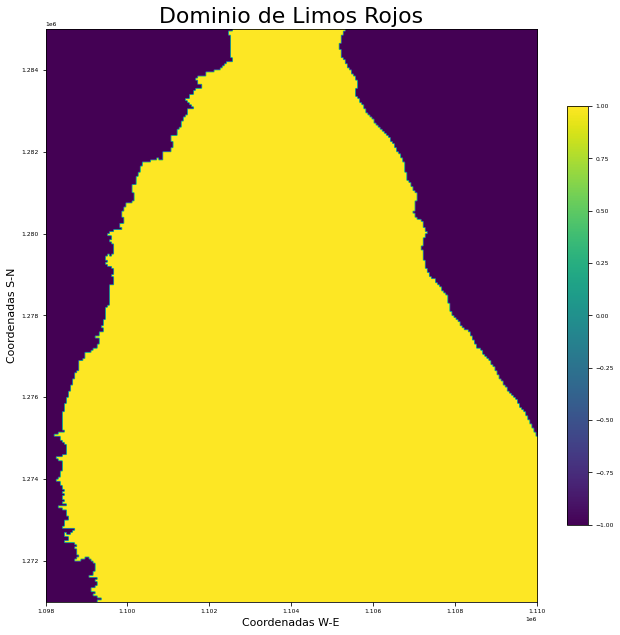

<Figure size 432x288 with 0 Axes>

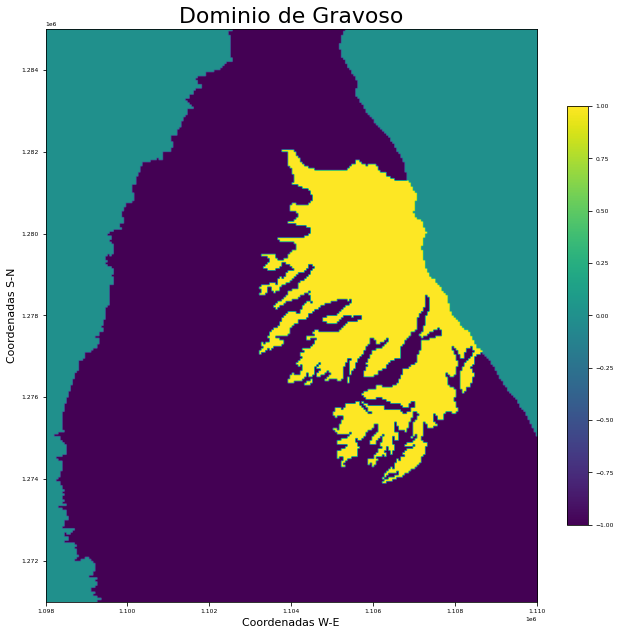

<Figure size 432x288 with 0 Axes>

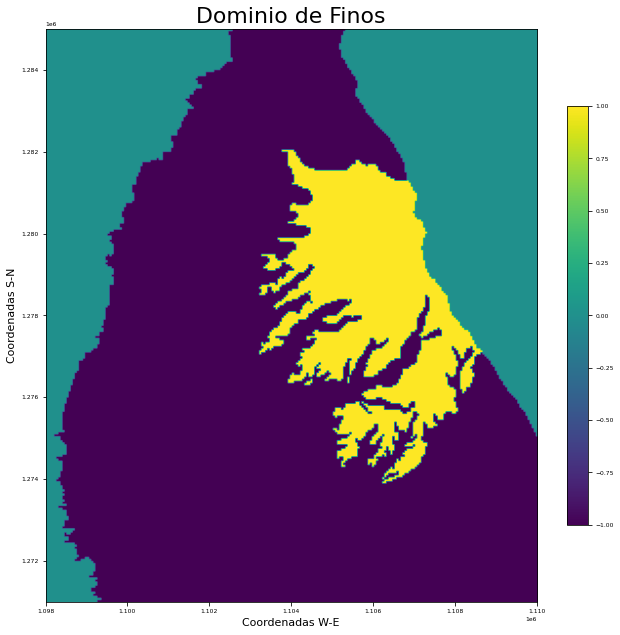

<Figure size 432x288 with 0 Axes>

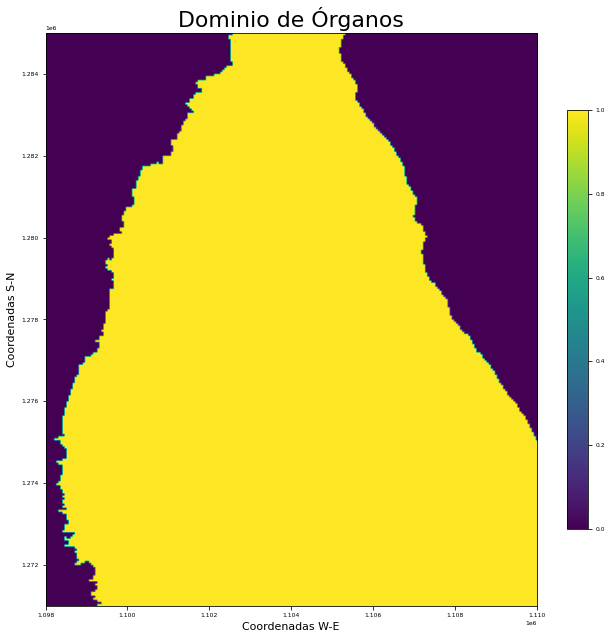

In [18]:
# CELDAS ACTIVAS: Dominio de la capa 1: Limos Rojos
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow(idomain[0],extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Dominio de Limos Rojos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Dominio de la capa 1 - Limos Rojos')

# CELDAS ACTIVAS/INACTIVAS. Dominio de la capa 2: Gravoso
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow(idomain[1],extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Dominio de Gravoso',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Dominio de la capa 2 - Gravoso')

# CELDAS ACTIVAS/INACTIVAS: Dominio de la capa 3: Finos 
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
#FormaGravoso[FormaGravoso>1.0e+38]=0
#FormaGravoso[FormaGravoso<-1.0e+38]=0

plt.imshow(idomain[2],extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Dominio de Finos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Dominio de la capa 3 - Finos')

# CELDAS ACTIVAS/INACTIVAS: Dominio de la capa 4: Órganos
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow(idomain[3],extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('Dominio de Órganos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Dominio de la capa 4 - Órganos')

In [19]:
# Horizontal hydraulic conductivity

kx0 = 1.1921e-4*np.ones([nrow,ncol])
kx0[idomain[0] == -1] = 1.1921e-4
kx0[idomain[1] == -1] = 1.1574e-7
kx0[idomain[2] == -1] = 4.167e-5
filnmkx0 = "hk0.txt"
np.savetxt(os.path.join(workspace,filnmkx0),kx0)

kx1 = 1.1921e-4*np.ones([nrow,ncol])
filnmkx1 = "hk1.txt"
np.savetxt(os.path.join(workspace,filnmkx1),kx1)

kx2 = 1.1574e-7*np.ones([nrow,ncol])
filnmkx2 = "hk2.txt"
np.savetxt(os.path.join(workspace,filnmkx2),kx2)

kx3 = 4.167e-5*np.ones([nrow,ncol])
filnmkx3 = "hk3.txt"
np.savetxt(os.path.join(workspace,filnmkx3),kx3)

kx=["hk0.txt","hk1.txt","hk2.txt","hk3.txt"]

# Vertical hydraulic conuctivity

kz0 = 2.1991e-5*np.ones([nrow,ncol])
kz0[idomain[0] == -1] = 2.1991e-5
kz0[idomain[1] == -1] = 1.0417e-7
kz0[idomain[2] == -1] = 1.736e-6
filnmkz0 = "vk0.txt"
np.savetxt(os.path.join(workspace,filnmkz0),kz0)

kz1 = 2.1991e-5*np.ones([nrow,ncol])
filnmkz1 = "vk1.txt"
np.savetxt(os.path.join(workspace,filnmkz1),kz1)

kz2 = 1.0417e-7*np.ones([nrow,ncol])
filnmkz2 = "vk2.txt"
np.savetxt(os.path.join(workspace,filnmkz2),kz2)

kz3 = 1.736e-6*np.ones([nrow,ncol])
filnmkz3 = "vk3.txt"
np.savetxt(os.path.join(workspace,filnmkz3),kz3)

kz=["vk0.txt","vk1.txt","vk2.txt","vk3.txt"]

In [20]:
# Hyraulic conuctivy is modified on the layer 'Limos rojos'
# only where the domain equals -1 on the next layers below it 
#kx[0][idomain[0] == -1] = kx[1,:,:]
###kx[0][idomain[1] == -1] = kx[2]
###kx[0][idomain[2] == -1] = kx[3]
###
###kz[0][idomain[0] == -1] = kz[1]
###kz[0][idomain[1] == -1] = kz[2]
###kz[0][idomain[2] == -1] = kz[3]

#
##kx[0][idomain[1] == -1] = 1.3 #kx[1,:,:]
#kx[1][idomain[2] == -1] = 0.001 #kx[2,:,:]
#kx[2][idomain[3] == -1] = 2.3 #kx[3,:,:]
#
#kz[0][idomain[1] == -1] = 0.1 #kz[1]
#kz[1][idomain[2] == -1] = 0.01 #kz[2]
#kz[2][idomain[3] == -1] = 0.1 #kz[3]

### Hydraulic conductivities graphic representation

### 1. Horizontal Conductivity

<Figure size 432x288 with 0 Axes>

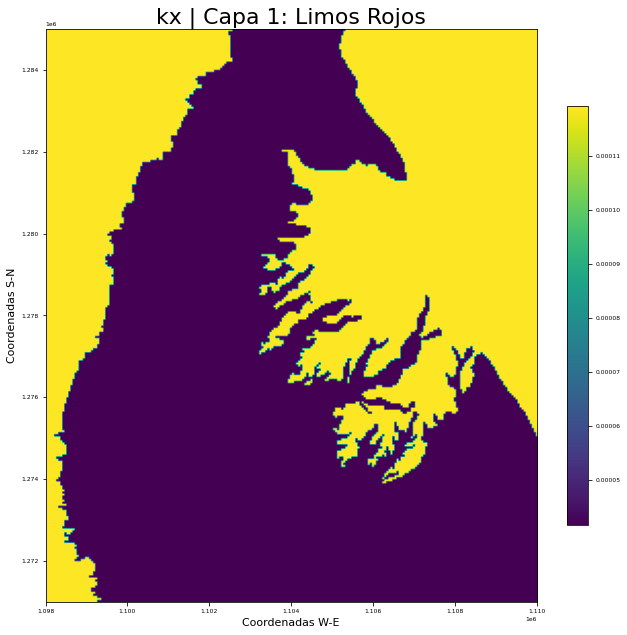

<Figure size 432x288 with 0 Axes>

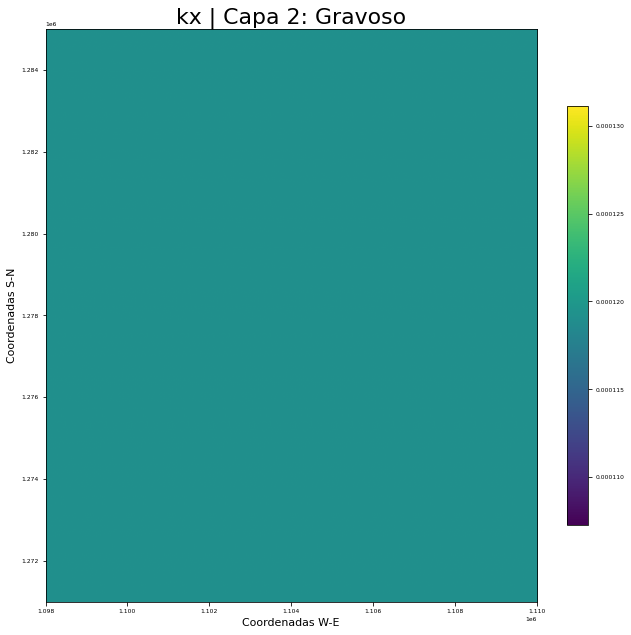

<Figure size 432x288 with 0 Axes>

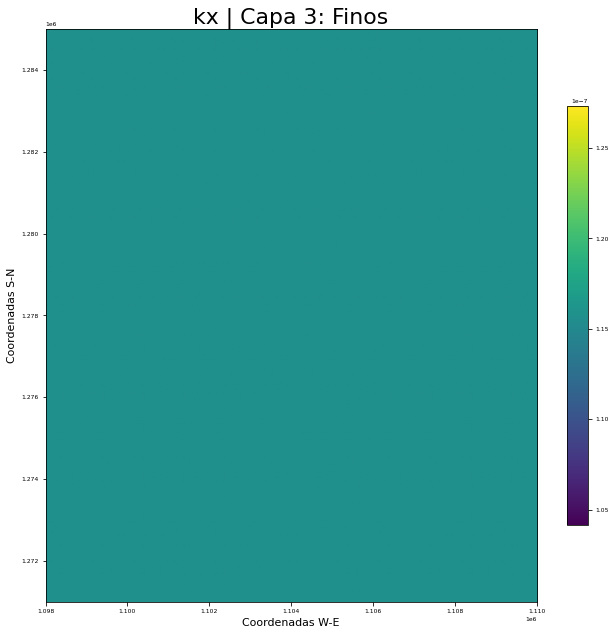

<Figure size 432x288 with 0 Axes>

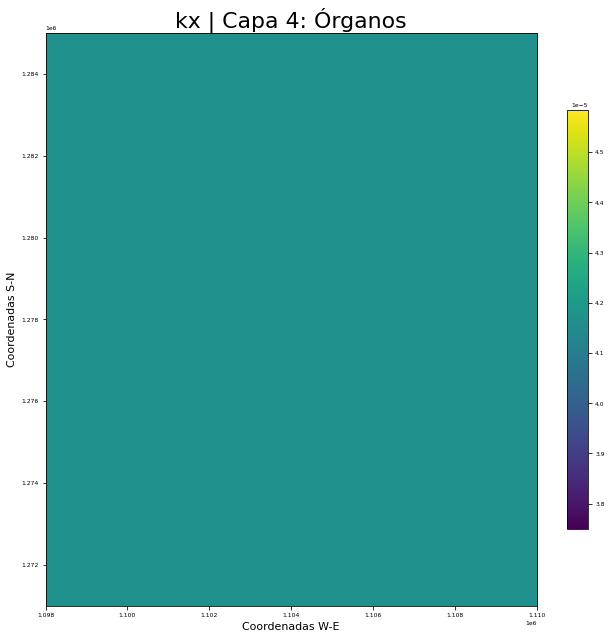

In [23]:
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kx0),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kx | Capa 1: Limos Rojos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kx de la capa 1 - Limos Rojos')

plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kx1),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kx | Capa 2: Gravoso',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kx de la capa 2 - Gravoso')

plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kx2),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kx | Capa 3: Finos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kx de la capa 3 - Finos')

plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kx3),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kx | Capa 4: Órganos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kx de la capa 4 - Órganos')

### 2. Vertical Conductivity kz

<Figure size 432x288 with 0 Axes>

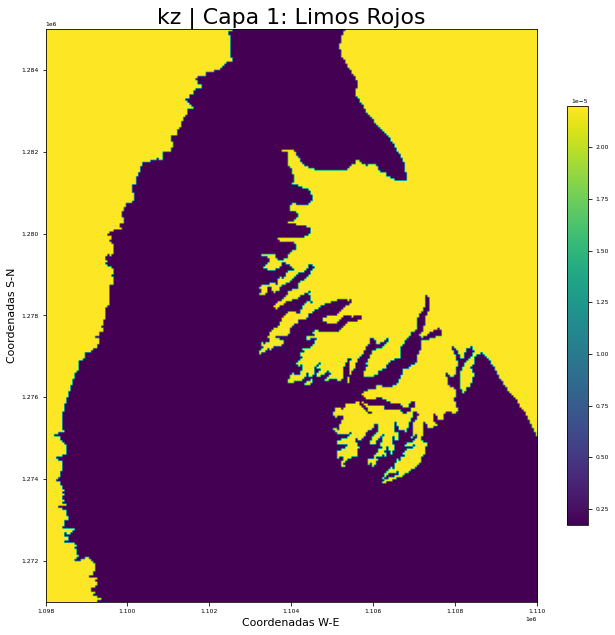

<Figure size 432x288 with 0 Axes>

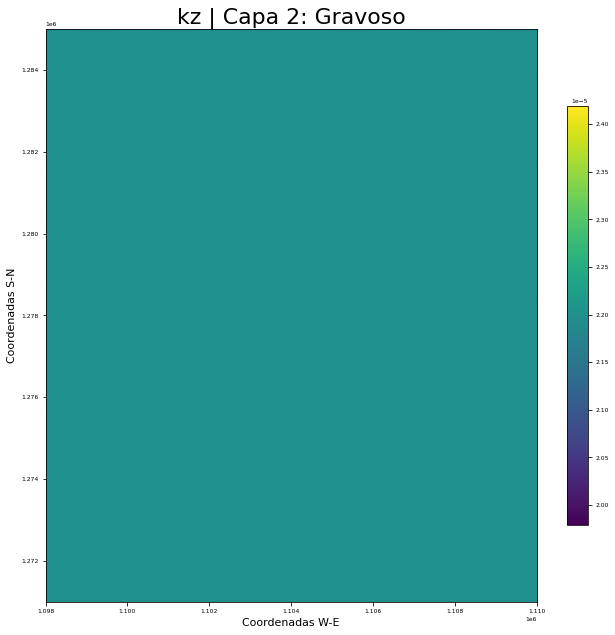

<Figure size 432x288 with 0 Axes>

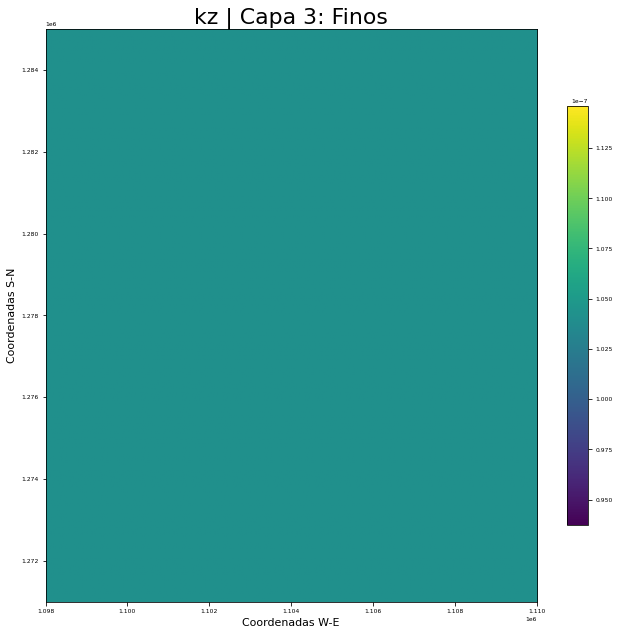

<Figure size 432x288 with 0 Axes>

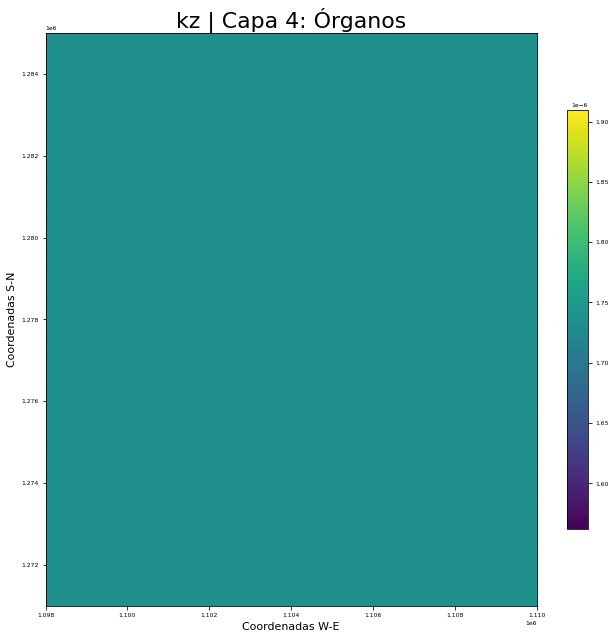

In [24]:
plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kz0),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kz | Capa 1: Limos Rojos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kz de la capa 1 - Limos Rojos')

plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kz1),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kz | Capa 2: Gravoso',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kz de la capa 2 - Gravoso')

plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kz2),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kz | Capa 3: Finos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kz de la capa 3 - Finos')

plt.figure()
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

plt.imshow((kz3),extent = extent)    
plt.xlabel('Coordenadas W-E',fontsize=11)
plt.ylabel('Coordenadas S-N',fontsize=11)
plt.title('kz | Capa 4: Órganos',fontsize = 22)
plt.colorbar(shrink=0.7);
#plt.savefig(fname='Conductividad Kz de la capa 4 - Órganos')

### Adding model river

In [25]:
# The raster contains real value numbers greater than zero in some cells of the array. 
# These are taken into account to create the stres_period_data 
# stressperioddata = (layer, row, col, stage, con., bottom)
river_values = np.column_stack(np.where(RiverStage > 0))
row = river_values[:, 0] #280
col = river_values[:, 1] #240

df_stage = pd.DataFrame(RiverStage)
stage = df_stage.to_numpy()[RiverStage > 0]

df_bottom = pd.DataFrame(RiverBottom)
bottom = df_bottom.to_numpy()[RiverBottom > 0]

In [26]:
# STRESS_PERIOD_DATA FOR RIVERS
spd_river = [[(0, row[i], col[i]), stage[i], 1.157e-4, bottom[i]]for i in range(len(row))]

### Water Head - CHD Package

In [27]:
# Same here, we select real values that are greater than zero. But this time is just to plot
# stressperioddata = (layer, row, col, head)
# CAPA 2
f_chd_2 = np.column_stack(np.where(headData_2 > 0))
row_chd_2 = f_chd_2[:, 0] #280
col_chd_2 = f_chd_2[:, 1] #240

df_chd = pd.DataFrame(headData_2)
head_2 = df_chd.to_numpy()[headData_2 > 0].astype(float)

In [28]:
# Same here, we select real values that are greater than zero. But this time is just to plot
# stressperioddata = (layer, row, col, head)
# CAPA 4
f_chd_4 = np.column_stack(np.where(headData_4 > 0))
row_chd_4 = f_chd_4[:, 0] #280
col_chd_4 = f_chd_4[:, 1] #240

df_chd = pd.DataFrame(headData_4)
head_4 = df_chd.to_numpy()[headData_4 > 0].astype(float)

In [29]:
spd_chd_2 = [] #Gravoso
for m in range(len(row_chd_2)):
    spd_chd_2.append([(1, row_chd_2[m], col_chd_2[m]), head_2[m]])
    
spd_chd_4 = [] #Órganos
for m in range(len(row_chd_4)):
    spd_chd_4.append([(3, row_chd_4[m], col_chd_4[m]), head_4[m]])

In [30]:
list_spd_chd = spd_chd_2 + spd_chd_4

In [31]:
# 3 celdas se encuentran fuera del acuífero superior, se ubican en Órganos:
#SN9, SN5 y “Norte” 
#sn9	893.12
#sn5	922.29
#norte	818.96

In [32]:
# Se carga el raster de observaciones
# Capa 2: Gravoso
pathobs = os.path.join("headsobs_layer2.tif")
headopenf = gdal.Open(pathobs)
headsobs_2 = headopenf.GetRasterBand(1).ReadAsArray()

#OBS
stackobs_2 = np.column_stack(np.where(headsobs_2 > 0))
row_obs_2 = stackobs_2[:, 0] #280
col_obs_2 = stackobs_2[:, 1] #240

dfobs_2 = pd.DataFrame(headsobs_2)
headobs_2 = dfobs_2.to_numpy()[headsobs_2 > 0]

In [33]:
# Se carga el raster de observaciones
# Capa 4: Órganos
pathobs = os.path.join("headsobs_layer4.tif")
headopenf = gdal.Open(pathobs)
headsobs_4 = headopenf.GetRasterBand(1).ReadAsArray()

#OBS
stackobs_4 = np.column_stack(np.where(headsobs_4 > 0))
row_obs_4 = stackobs_4[:, 0] #280
col_obs_4 = stackobs_4[:, 1] #240

dfobs_4 = pd.DataFrame(headsobs_4)
headobs_4 = dfobs_4.to_numpy()[headsobs_4 > 0]

In [34]:
obs_2 = [("{}_{}_{}".format(2, row_obs_2[i],col_obs_2[i]),
            "HEAD",
            (1, row_obs_2[i], col_obs_2[i])) for i in range(len(row_obs_2))]

obs_4 = [("{}_{}_{}".format(4, row_obs_4[i],col_obs_4[i]),
            "HEAD",
            (3, row_obs_4[i], col_obs_4[i])) for i in range(len(row_obs_4))]

In [35]:
obs = obs_2 + obs_4

In [36]:
##stackgrav = np.column_stack(np.where(FormaGravoso > 0))
##row_grav = stackgrav[:, 0] #280
##col_grav = stackgrav[:, 1] #240
##
###OBS
##lst_pts = []
##for irow in range(range(len(row_grav))[0],len(row_grav),7):
##    for icol in range(range(len(col_grav))[0],len(col_grav),7):
##        lst_pts.append((1,irow,icol))
##            
##spd_obs=[]
##for pts in lst_pts:
##    spd_obs.append(("1_{}_{}".format(pts[1],pts[2]),"HEAD",pts))

In [37]:
obs_recarray = {('heads.csv'):obs}

In [45]:
### Paquetes de Modflow 6

# Crear el paquete de simulación SIM
sim = flopy.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name=exe_name, sim_ws=workspace)

# Crear el paquete de discretización temporal TDIS
tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='SECONDS', nper=1, perioddata=[(1.0, 1, 1.0)])

# Crear el objeto GWF del modelo
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, model_nam_file='{}.nam'.format(model_name),version='mf6',exe_name=exe_name, print_flows=True,save_flows=True, newtonoptions=True)
gwf.modelgrid.set_coord_info(epsg=3116,proj4=3116)

# Crear el paquete de solucionador del modelo iterativo (IMS)
# Simple complexity; used for models not including stress or models either
# confined or w/ a single unconfined layer.
ims = flopy.mf6.ModflowIms(sim, print_option='ALL', pname='ims', complexity='complex', under_relaxation='DBD', linear_acceleration='BICGSTAB')
#,

# Crear el paquete de discretización
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, delc=delc, delr=delr, top=ztop, botm=zbot, idomain=idomain, length_units='METERS', xorigin=xll, yorigin=yll, filename='{}.dis'.format(model_name))

# Create the initial conditions package IC (former BAS). STRT es la cabeza inicial al inicio de la simulación del modelo GWF. Debe ser especificado para todas las simulaciones incluso en estado permanente.
ic = flopy.mf6.ModflowGwfic(gwf, pname='ic', strt=strt)

In [56]:
# Crear el paquete node property flow (former LPF)
# icelltype: 1=Convertible 0=Confined -1=Unconfined
npf = flopy.mf6.ModflowGwfnpf(gwf, pname='npf', k=kx, k33=kz, icelltype =0, save_flows=True, save_specific_discharge=True)

In [57]:
# STRESS_PERIOD_DATA FOR CONSTANT HEADS
##spd_chd = [[(1, row_chd[m], col_chd[m]), head[m]+10.] for m in range(len(row_chd))]
# Create constant head package
chd = flopy.mf6.ModflowGwfchd(gwf, pname='chd', maxbound=len(head_2)+len(head_4), save_flows=True, stress_period_data = list_spd_chd)

In [58]:
# Create river package
# STRESS_PERIOD_DATA FOR RIVERS
spd_river = [[(0, row[i], col[i]), stage[i], 1.157e-4, bottom[i]]for i in range(len(row))]
river = flopy.mf6.ModflowGwfriv(gwf, pname='riv', save_flows=True, maxbound=len(row), stress_period_data = spd_river)

In [59]:
# OBS PACKAGE
obs_package = flopy.mf6.ModflowUtlobs(gwf,pname='head_obs',filename='{}.obs'.format(model_name), print_input=True,
                                         continuous=obs_recarray)

In [60]:
### Ejecución del modelo

#Output Control
oc   = flopy.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'ALL'), 
                                        ('BUDGET', 'ALL')],
                            printrecord=[('BUDGET', 'ALL')])
#Write the datasets
sim.write_simulation()

# RUN THE SIMULATION
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model mf6model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd...
    writing package riv...
    writing package head_obs...
    writing package oc...
FloPy is using the following  executable to run the model: .\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.0 10/22/2020

   MODFLOW 6 compiled Oct 22 2020 09:26:42 with IFORT compiler (ver. 19.10.2)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. 

(False, [])

In [61]:
#list_spd_chd for m in range(len(row_chdO)+len(row_chd))

In [ ]:
sr=pyemu.utils.helpers.SpatialReference(xul=xul,yul=yul,delc=(np.ones(nrow, dtype=float) * delr),delr=(np.ones(ncol, dtype=float) * delr),rotation=0.0, epsg='3116')

In [ ]:
sr

In [ ]:
# empty pst from object
template_ws = "template"
pf = pyemu.utils.PstFrom(original_d=workspace, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False)

In [ ]:
#add observation
df = pd.read_csv(os.path.join(template_ws,"targets.csv"),index_col=0)

hds_df = pf.add_observations("targets.csv",insfile="targets.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="hds",obsgp=False)

case = "pest_test"
pf.build_pst("{}.pst".format(case))

In [ ]:
ppspace=111
a = ppspace*3.0
v = pyemu.geostats.GauVario(contribution=1.0,a=a)
grid_gs = pyemu.geostats.GeoStruct(variograms=v, transform='log')

fig = plt.figure(figsize=(8,4))
grid_gs.plot()
print("spatial variogram")

In [ ]:
pf.add_parameters(filenames="hk0.txt",par_type="pilotpoint",pp_space=ppspace,
                   par_name_base="kp",pargp="hp", zone_array=idomain[0],
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs)
#
#pf.add_parameters(filenames="hk1.txt",par_type="pilotpoint",pp_space=ppspace,
#                   par_name_base="kp",pargp="hp", zone_array=idomain[1],
#                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs)
#
#pf.add_parameters(filenames="vk0.txt",par_type="pilotpoint",pp_space=ppspace,
#                   par_name_base="kp",pargp="vp", zone_array=idomain[0],
#                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs)
#
#pf.add_parameters(filenames="vk1.txt",par_type="pilotpoint",pp_space=ppspace,
#                   par_name_base="kp",pargp="vp", zone_array=idomain[1],
#                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs)

In [ ]:
# add run model command
pf.mod_sys_cmds.append("mf6.exe")
pf.build_pst("{}.pst".format(case))

In [ ]:
#Rewrite ins file because Pyemu isn't smart enough

file = "template/targets.csv.ins"
fileout = "template/targets2.csv.ins"
with open(file) as f:
    with open(fileout,"w") as fout:
        for i,line in enumerate(f):
            if i < 2:
                fout.write(line)
            if i > 1:
                for o,split in enumerate(line.split("w")):
                    if o == 1:
                        fout.write("~,~")
                    fout.write(split)
                        
from shutil import copyfile
copyfile(fileout, file) # copy 
os.remove(fileout) # delete tmp file

In [ ]:
pst = pf.build_pst("{}.pst".format(case))
cov = pf.build_prior()
x = cov.x.copy()
x[x==0.0] = np.NaN
fig,ax = plt.subplots(1,1,figsize=(7,7))
g = ax.imshow(x)

In [ ]:
t_d = "template"
m_d = "master_glm"

pst.control_data.noptmax = 0 # FOR JACOBIAN
pst.write(os.path.join(t_d,"{}.pst".format(case)))

In [ ]:
# calculate
n = 4 #select number of workers
pyemu.os_utils.start_workers(t_d,"../pestpp-glm.exe","{}.pst".format(case),num_workers=n,worker_root=".",master_dir=m_d)